<div style = "text-align: right"><h4>Job Oriented Specialisation in Data Science</h4></div>

---
<center><h1>Clustering</h1></center>

---

## Project - Segmenting customers into clusters

### Perform Customer Segmentation on the transactional data to build an efficient marketing model. This is a transactional data set that contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a registered non-store online retail.

#### Invoice No: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
#### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
#### Description: Product (item) name. Nominal.
#### Quantity: The quantities of each product (item) per transaction. Numeric.
#### Invoice Date: Invoice Date and time. Numeric, the day and time when each transaction was generated.
#### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
#### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
#### Country: Country name. Nominal, the name of the country where each customer resides.

---

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [2]:
# Reading the dataset
data = pd.read_excel('Project 6-Segmenting customers into clusters-Dataset.xlsx')

In [3]:
# Reading first few lines of data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Shape of the data
data.shape

(541909, 8)

### Data Preprocessing

#### Checking missing values

In [5]:
# Percentage of missing values in each variable
data.isnull().sum()/len(data)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

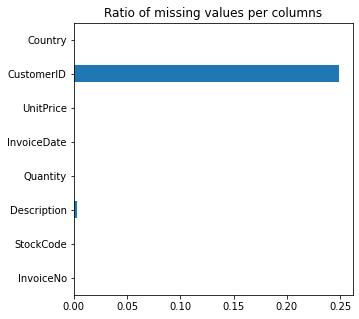

In [6]:
# Visualizing ratio of missing values
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")
plt.show()

We can't keep the data without any value in the **`CustomerID`** column since we want to classify the customers. So we'll drop the lines with NaN values on the CustomerID column.

In [7]:
# Dropping the null values from CustomerID column
data = data.dropna(subset=["CustomerID"])

In [8]:
# percentage of missing values in each variable
data.isnull().sum()/len(data)*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

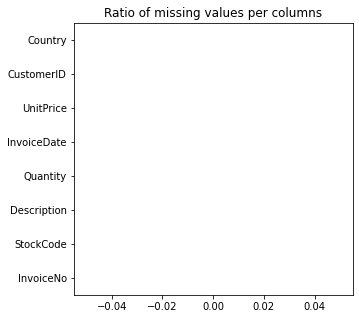

In [9]:
# Ratio of missing values

plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")
plt.show()

As we can see after removing null values from the **`CustomerID`** variable, null values from the **`Description`** variable have also been removed.

#### Checking data type of variables

In [10]:
# Checking the data types of each feaure
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [11]:
# Since our dataset is containing features `InvoiceNo` and `StockCode` having mixed values as int and str type, we will convert
# them to string.
data.InvoiceNo = data.InvoiceNo.astype(str)
data.StockCode = data.StockCode.astype(str)

In [12]:
# Extracting the Month, Weekday and Hour of the invoice
data['InvoiceDate_month'] = data['InvoiceDate'].dt.month
data['InvoiceDate_weekday'] = data['InvoiceDate'].dt.weekday
data['InvoiceDate_hour'] = data['InvoiceDate'].dt.hour

### Since the **`InvoiceNo`** is containing cancelled orders also, we will check the amount of cancelled orders if it is significant or not.

In [13]:
# Constucting a groupby dataframe
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
number_of_products_per_group = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [14]:
# Finding the cancelled orders and imputing 1 if it is cancelled otherwise 0.
number_of_products_per_group['order_cancelled'] = number_of_products_per_group['InvoiceNo'].apply(lambda x:int('C' in x))

# Percent cancelled orders.
len(number_of_products_per_group[number_of_products_per_group['order_cancelled']==1])/len(number_of_products_per_group)*100

16.466876971608833

It appears that more than **`16%`** of the transactions were cancelled which is **significant**.

Let us take these cancelled order in account to the main dataframe.

In [15]:
# Applying lambda function over the whole dataset
data['order_cancelled'] = data['InvoiceNo'].apply(lambda x:int('C' in x))

In [16]:
# Looking at the cancelled order rows
data[data['order_cancelled']==1].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_month,InvoiceDate_weekday,InvoiceDate_hour,order_cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,12,2,9,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,12,2,9,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,12,2,10,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,10,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,12,2,10,1


In [17]:
# Checking the data type
data.dtypes

InvoiceNo                      object
StockCode                      object
Description                    object
Quantity                        int64
InvoiceDate            datetime64[ns]
UnitPrice                     float64
CustomerID                    float64
Country                        object
InvoiceDate_month               int64
InvoiceDate_weekday             int64
InvoiceDate_hour                int64
order_cancelled                 int64
dtype: object

In [18]:
# dropping the InvoiceDate column as we have extracted the datetime variables.
data = data.drop('InvoiceDate', axis = 1)

#### Label encoding the string variables

In [19]:
# Importing Label Encoder for converting the categorical values to numeric value
from sklearn.preprocessing import LabelEncoder

In [20]:
# Transforming each feature
le = LabelEncoder()
label_InvoiceNo = le.fit_transform(data['InvoiceNo'])
label_StockCode = le.fit_transform(data['StockCode'])
label_Description = le.fit_transform(data['Description'])
label_Country = le.fit_transform(data['Country'])

In [21]:
# Storing the generated label in their respective columns
data['InvoiceNo'] = label_InvoiceNo
data['StockCode'] = label_StockCode
data['Description'] = label_Description
data['Country'] = label_Country

#### Scaling the data

In [22]:
# Importing Standard Scaler and fitting the scaled data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)

In [23]:
# Checking the scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05,4.068290e+05
mean,-5.365368e-17,-5.952205e-17,3.807455e-18,-4.523536e-18,5.868371e-18,-3.051553e-16,3.906659e-16,-2.235570e-18,-1.318986e-16,-1.933768e-16,2.333376e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.792216e+00,-1.863931e+00,-1.858922e+00,-3.257311e+02,-4.992379e-02,-1.716675e+00,-4.871627e+00,-1.932163e+00,-1.356156e+00,-2.948631e+00,-1.495949e-01
25%,-8.808803e-01,-7.538118e-01,-8.095044e-01,-4.045671e-02,-3.189019e-02,-7.788819e-01,3.223641e-01,-7.622096e-01,-8.358387e-01,-7.603986e-01,-1.495949e-01
50%,6.467571e-02,-6.072778e-02,-3.460664e-02,-2.839365e-02,-2.179138e-02,-7.918459e-02,3.223641e-01,1.152558e-01,-3.155215e-01,1.148945e-01,-1.495949e-01
75%,8.465154e-01,6.311714e-01,8.449574e-01,-2.465022e-04,4.176999e-03,8.772823e-01,3.223641e-01,9.927212e-01,7.251129e-01,5.525410e-01,-1.495949e-01
max,2.204154e+00,2.499536e+00,1.717176e+00,3.256341e+02,5.621654e+02,1.750299e+00,4.707639e-01,1.285210e+00,1.765747e+00,3.178420e+00,6.684718e+00


### Kmeans clustering

In [24]:
# Appending the result of inertia in a blank list named SSE, after fitting the scaled data into kmeansfor each number
# of clusters.
SSE_scaled = []

for cluster in range(1,15):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster)
    kmeans.fit(data_scaled)
    SSE_scaled.append(kmeans.inertia_)

In [25]:
# Creating a dataframe
frame_scaled = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE_scaled})

#### Elbow Curve for clusters

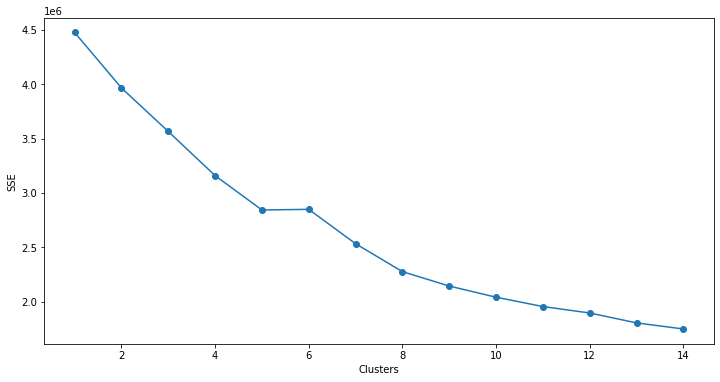

In [26]:
# Plotting the Elbow curve
plt.figure(figsize=(12,6))
plt.plot(frame_scaled['Cluster'], frame_scaled['SSE'], marker='o')
plt.xlabel("Clusters")
plt.ylabel("SSE")
plt.show()

*From the above elbow curve, we can observe that the optimum value for number of clusters is 7.*

In [27]:
# Fitting the data and predicting the clusters
kmeans = KMeans(n_jobs = -1, n_clusters = 7)
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [28]:
# predicted clusters
pred

array([0, 0, 0, ..., 2, 2, 2])

In [29]:
# Creating a dataframe of scaled data
frame = pd.DataFrame(data_scaled)

In [30]:
# Inserting a column name cluster and putting the predicted values of clusters
frame['cluster'] = pred

In [31]:
# Number of data points allocated to each cluster
frame['cluster'].value_counts()

6    111061
0     97192
3     85672
1     69835
2     34164
4      8904
5         1
Name: cluster, dtype: int64

In [32]:
# Checking the dataframe with clusters
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,-1.792216,1.985351,1.552832,-0.024373,-0.013135,1.49528,0.322364,1.28521,-0.315521,-2.073338,-0.149595,0
1,-1.792216,1.274496,1.560177,-0.024373,-0.001017,1.49528,0.322364,1.28521,-0.315521,-2.073338,-0.149595,0
2,-1.792216,1.518556,-1.068416,-0.016331,-0.010250,1.49528,0.322364,1.28521,-0.315521,-2.073338,-0.149595,0
3,-1.792216,1.456948,-0.194360,-0.024373,-0.001017,1.49528,0.322364,1.28521,-0.315521,-2.073338,-0.149595,0
4,-1.792216,1.455764,0.689794,-0.024373,-0.001017,1.49528,0.322364,1.28521,-0.315521,-2.073338,-0.149595,0


***After we predicted the clusters for each of the data elements, above dataframe shows that out of the 7 clusters, which data item will belong to which cluster.***